# Projeto de análise das Atas do Copom

## Pacotes

In [2]:
from bs4 import BeautifulSoup as Soup
import requests #Web Scraping
import json #Tranformar dados em Json
import pandas as pd #Tratamento de dados
from urllib.parse import urljoin #Concatenar URLs
from PyPDF2 import PdfFileReader #Extração de textos dos PDFs
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jairo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jairo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Web Scraping

In [3]:
url = "https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/ultimas?quantidade=1000&filtro="

payload = {}
headers = {
  'authority': 'www.bcb.gov.br',
  'accept': 'application/json, text/plain, */*',
  'accept-language': 'pt-BR,pt;q=0.9,en;q=0.8',
  'cookie': 'BIGipServer~site_internet_azure_p_as3~site_internet_azure_p~pool_cluster_www_443_p=rd2o00000000000000000000ffffc8dad042o443; _gid=GA1.3.1928060446.1698534390; bcb-aceitacookie=true; ASPSESSIONIDSUCRQSRS=PEOGHEBCHPDGAJJMICPJOLJH; _ga_TPS4R7DC1S=GS1.1.1698534389.3.1.1698534828.59.0.0; _ga=GA1.1.1533208214.1698443841',
  'if-none-match': '"875fd9f3-281a-438b-946f-26ddad07bf86"',
  'referer': 'https://www.bcb.gov.br/en/publications/copomminutes/cronologicos',
  'sec-ch-ua': '"Chromium";v="118", "Microsoft Edge";v="118", "Not=A?Brand";v="99"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'same-origin',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36 Edg/118.0.2088.69'
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)


{"conteudo":[{"DataReferencia":"2023-11-01T03:00:00Z","ImagemCapa":"/content/publications/PublishingImages/Capas/copomminutes/capa-copomminutes.png","Titulo":"258th Meeting - October 31 - November 1, 2023","Url":"/content/copom/copomminutes/MINUTES 258.pdf","LinkPagina":"/en/publications/copomminutes/01112023","EsconderDataReferencia":true},{"DataReferencia":"2023-09-20T03:00:00Z","ImagemCapa":"/content/publications/PublishingImages/Capas/copomminutes/capa-copomminutes.png","Titulo":"257th Meeting - September 19-20, 2023","Url":"/content/copom/copomminutes/MINUTES 257.pdf","LinkPagina":"/en/publications/copomminutes/20092023","EsconderDataReferencia":true},{"DataReferencia":"2023-08-02T03:00:00Z","ImagemCapa":"/content/publications/PublishingImages/Capas/copomminutes/capa-copomminutes.png","Titulo":"256th Meeting - August 1-2, 2023","Url":"/content/copom/copomminutes/MINUTES 256.pdf","LinkPagina":"/en/publications/copomminutes/02082023","EsconderDataReferencia":true},{"DataReferencia":

## Tratamento de dados

In [ ]:
dados=response.json() #Dados em Json
dados

In [ ]:
df = pd.DataFrame(dados['conteudo']) #DataFrame dos Dados
df

In [ ]:
df1 = df.drop(['ImagemCapa', 'EsconderDataReferencia'], axis=1) #Limpando as colunas desnecessárias
df1

In [ ]:
df1 = df1.dropna(axis=1)
df1

In [107]:
# Função para criar coluna com os números das reuniões
def extrair_numero(text):
    match = re.search(r'(\d+)', text)  # Encontra a primeira sequência de dígitos
    if match:
        return int(match.group(1))  # Converte para int
    return None

In [ ]:
df1['Numero'] = df['Titulo'].apply(extrair_numero)
df1

In [109]:
# Concatenando a coluna 'URL' com a parte fixa
df1['URL_completa'] ='https://www.bcb.gov.br' + df1['Url']

# Exibindo o DataFrame
df1.head(2)

,DataReferencia,Titulo,Url,LinkPagina,Numero,URL_completa
0,2023-11-01T03:00:00Z,"258th Meeting - October 31 - November 1, 2023",/content/copom/copomminutes/MINUTES 258.pdf,/en/publications/copomminutes/01112023,258.0,https://www.bcb.gov.br/content/copom/copomminu...
1,2023-09-20T03:00:00Z,"257th Meeting - September 19-20, 2023",/content/copom/copomminutes/MINUTES 257.pdf,/en/publications/copomminutes/20092023,257.0,https://www.bcb.gov.br/content/copom/copomminu...


## Extração dos textos a partir dos PDF's

In [110]:
def extrair_texto_de_pdf(link, pagina_inicial=3):
    try:
        response = requests.get(link)
        if response.status_code == 200:
            with open("temp.pdf", "wb") as pdf_file:
                pdf_file.write(response.content)

            pdf_reader = PdfReader("temp.pdf")
            texto = ""
            for page_num in range(pagina_inicial - 1, len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                texto += page.extract_text()

            return texto
    except Exception as e:
        print(f"Erro ao extrair texto do PDF: {e}")
        return None


In [117]:
df1['texto_extraido'] = df1['URL_completa'].apply(extrair_texto_de_pdf)

## Tratamento dos textos

In [111]:
df1.columns

Index(['DataReferencia', 'Titulo', 'Url', 'LinkPagina', 'Numero',
       'URL_completa'],
      dtype='object')

In [ ]:
df1.drop(214)

In [ ]:
df1["texto_extraido"]

In [ ]:
#Tabela com textos
print(df1["texto_extraido"].iloc[0])

In [120]:
# Palavras a serem excluídas
palavras_excluir = ['copom', 'month', 'year',]

In [121]:
stop_words = set(stopwords.words('english'))

In [140]:
df1.loc[:, 'texto_extraido'] = df1['texto_extraido'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.isalpha() and len(word) > 2 and word.lower() not in stop_words and word.lower() not in palavras_excluir]))

In [141]:
word_counts = Counter(' '.join(df1['texto_extraido']).split())

In [142]:
top_words = word_counts.most_common(10)

In [146]:
top_words = word_counts.most_common(5)
top_words

[('inflation', 6720),
 ('rate', 4809),
 ('prices', 4171),
 ('increased', 3388),
 ('billion', 3318)]

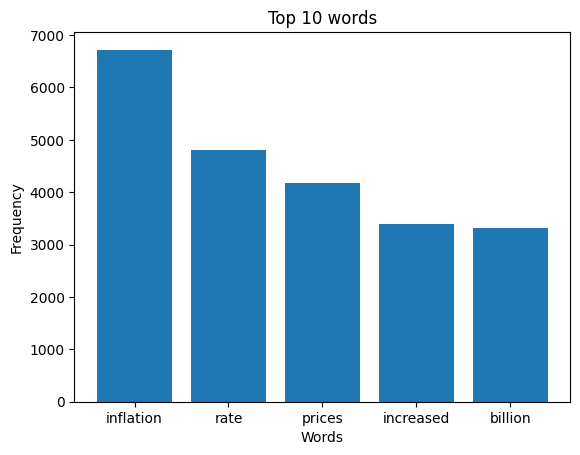

In [144]:
words, counts = zip(*top_words)
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 words')
plt.show()